In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from wordcloud import STOPWORDS
import numpy as np
import string
from nltk.corpus import stopwords
from collections import defaultdict, Counter
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import re
from tqdm import tqdm

### Brief description of the problem and data

Briefly describe the challenge problem and NLP. Describe the size, dimension, structure, etc., of the data. 

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train_copy = train.copy()
test_copy = test.copy()
print('Sample of Test:\n')
test.head(5)

Sample of Test:



,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [3]:
print('Sample of Train:\n')
train.head(5)

Sample of Train:



,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
print('There are {} rows and {} columns in train'.format(train.shape[0],train.shape[1]))
print('There are {} rows and {} columns in test'.format(test.shape[0],test.shape[1]))

There are 7613 rows and 5 columns in train
There are 3263 rows and 4 columns in test


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [6]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None


### Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

Show a few visualizations like histograms. Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis? 

#### Class Imbalance: Target

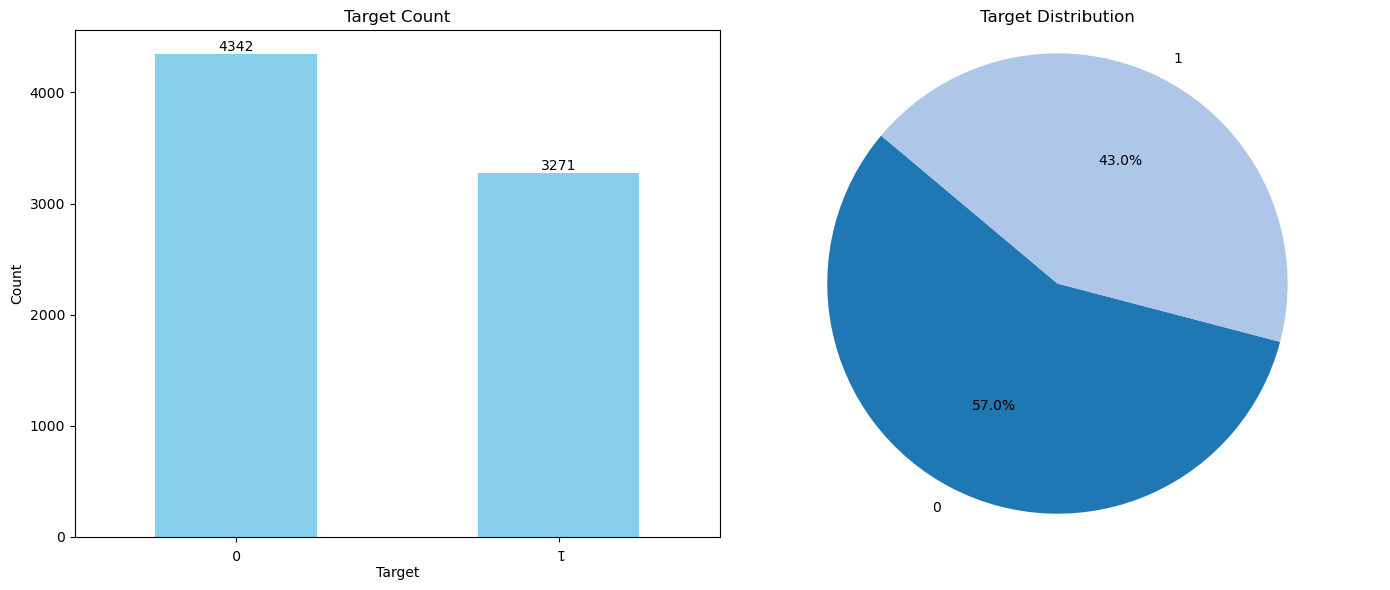

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

cnt_srs = train['target'].value_counts()
cnt_srs.plot(kind='bar', color='skyblue', ax=axs[0])
axs[0].set_title('Target Count')
axs[0].set_xlabel('Target')
axs[0].set_ylabel('Count')
axs[0].tick_params(axis='x', rotation=180)

for i, count in enumerate(cnt_srs):
    axs[0].text(i, count + 0.1, str(count), ha='center', va='bottom')

axs[1].pie(cnt_srs, labels=cnt_srs.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.tab20.colors)
axs[1].set_title('Target Distribution')
axs[1].axis('equal')
plt.tight_layout()
plt.show()


The target column in the training dataset indicates that there are 4,342 records classified as 0 (non-disaster tweets) and 3,271 records classified as 1 (disaster tweets). This distribution translates to 43% for disaster tweets and 57% for non-disaster tweets. The data exhibits a slight imbalance, with a higher proportion leaning towards non-disaster tweets.

#### Non-Disaster and Disaster Tweet by Location

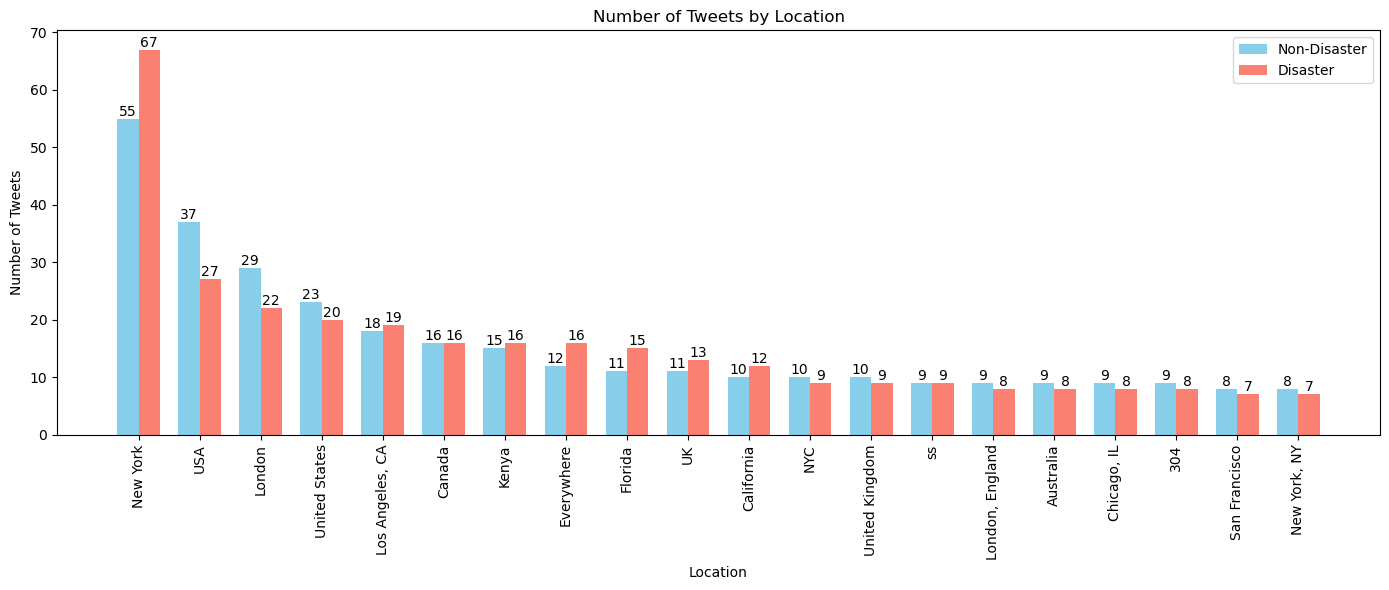

In [8]:
disaster = train[train["target"] == 1]
non_disaster = train[train["target"] == 0]

cnt_disaster = disaster['location'].value_counts().head(20)
cnt_non_disaster = non_disaster['location'].value_counts().head(20)

x = np.arange(len(cnt_non_disaster))
plt.figure(figsize=(14, 6))

bar_width = 0.35  
plt.bar(x - bar_width/2, cnt_non_disaster.values, bar_width, color='skyblue', label="Non-Disaster")
plt.bar(x + bar_width/2, cnt_disaster.values, bar_width, color='salmon', label="Disaster")

for i, v in enumerate(cnt_non_disaster.values):
    plt.text(i - bar_width/2, v, str(v), ha='center', va='bottom')
for i, v in enumerate(cnt_disaster.values):
    plt.text(i + bar_width/2, v, str(v), ha='center', va='bottom')

plt.title('Number of Tweets by Location')
plt.xlabel('Location')
plt.ylabel('Number of Tweets')
plt.xticks(ticks=x, labels=cnt_non_disaster.index, rotation=90)  # Set the tick positions and labels
plt.legend()
plt.tight_layout()

plt.show()

The location with the highest number of tweets, both related to disasters and non-disasters, is New York state, with variations such as "New York," "NYC," and "New York, NY" comprising a total of 73 non-disaster tweets and 83 disaster tweets. California ranks as the state with the second-highest tweet count, with variations like "Los Angeles, CA," "California," and "San Francisco" accumulating 36 non-disaster tweets and 38 disaster tweets. 

The United States ranks as the country with the highest tweet count, with variations like "USA" and "United States" totaling 60 non-disaster tweets and 47 disaster tweets not including individual cities or states. On the international scale, the United Kingdom secured the second spot, with variations like "UK" and "United Kingdom" not including individual cities or provinces, amassing 21 non-disaster tweets and 22 disaster tweets.

These numbers suggest that urban hubs and densely populated regions tend to generate more tweet activity, possibly due to a higher concentration of users and a greater likelihood of both disasters and non-disaster events occurring. Additionally, it highlights the global reach and significance of platforms like Twitter in capturing real-time information and discussions around various events and incidents.

#### Word Length Density for Non-Disaster vs Disaster Tweets

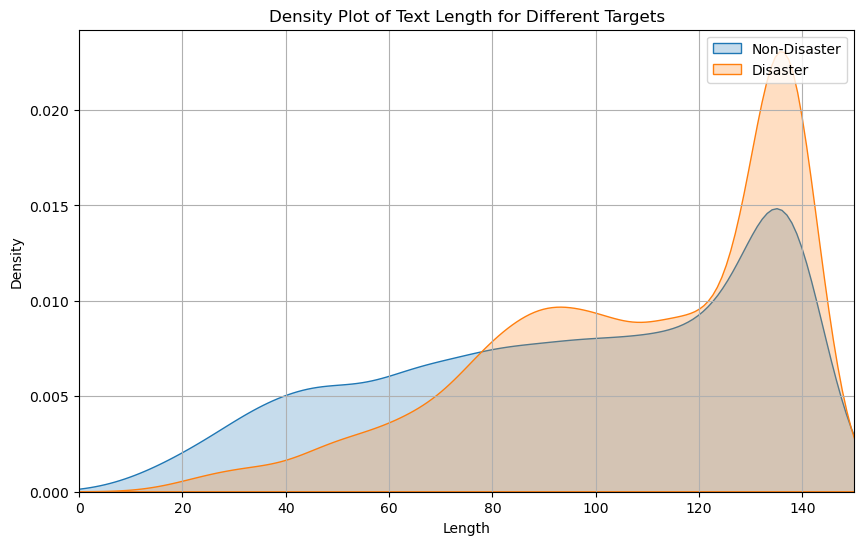

In [9]:
warnings.filterwarnings("ignore", message="use_inf_as_na option is deprecated", category=FutureWarning)
train['length'] = train['text'].apply(len) 
plt.rcParams['figure.figsize'] = (10.0, 6.0)
sns.kdeplot(train[train['target'] == 0]['length'], fill=True, label='Non-Disaster')
sns.kdeplot(train[train['target'] == 1]['length'], fill=True, label='Disaster')
plt.xlabel('Length')
plt.ylabel('Density')
plt.legend(loc='upper right')
plt.title('Density Plot of Text Length for Different Targets')
plt.xlim(0, 150)
plt.grid()
plt.show()

The density of non-disaster tweets reaches its highest point, around 0.015, when the word length is approximately 138 words. Initially, there's a slight peak at a density of around 0.005, occurring around 40 words, followed by a more significant peak at 0.015. After this peak, the density sharply declines.

In contrast, disaster tweets exhibit a different pattern. Their density surpasses 0.020 at around 138 words, indicating a higher concentration of information compared to non-disaster tweets. The density plot for disaster tweets shows a steady increase, with two notable peaks. The first peak, slightly smaller, occurs at around 90 words with a density of about 0.009. The second peak is more pronounced, reaching above 0.020. Following this peak, the density sharply declines.

These numbers suggest that disaster tweets tend to be more densely packed with information compared to non-disaster tweets, especially evident in the second peak. 

#### Word, UniqueWord, StopWord Text Distribution in Non-Disaster and Disaster Tweets

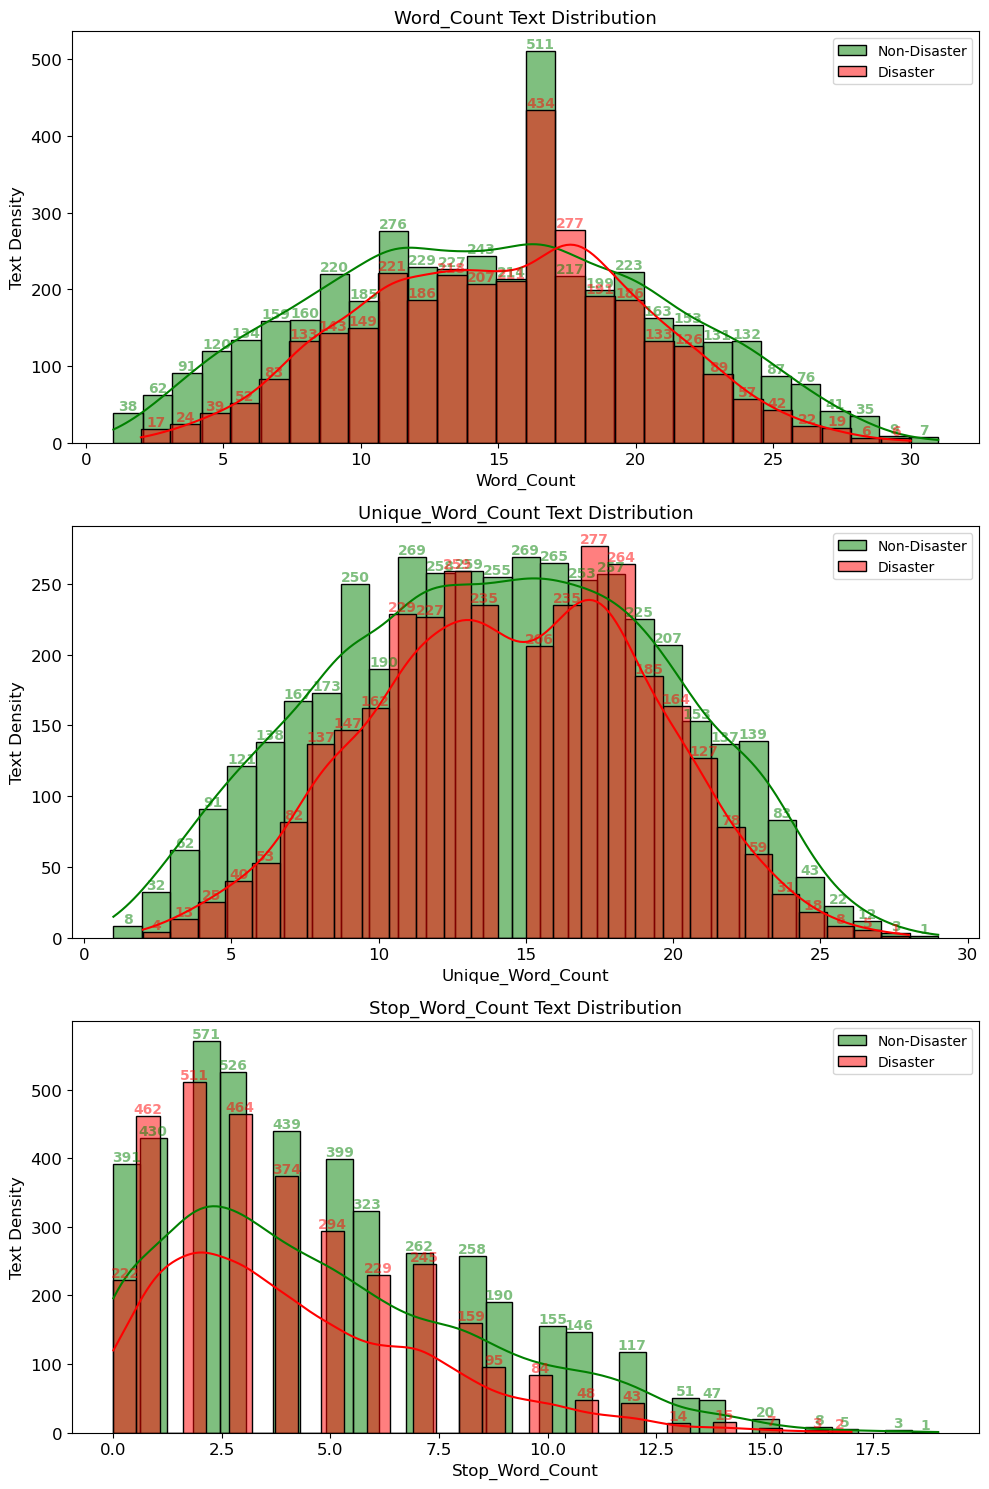

In [10]:
STOPWORDS = set(stopwords.words('english'))

def preprocess_text(text):
    return str(text).lower()

def calculate_text_features(df):
    df['Word_Count'] = df['text'].apply(lambda x: len(str(x).split()))
    df['Unique_Word_Count'] = df['text'].apply(lambda x: len(set(str(x).split())))
    df['Stop_Word_Count'] = df['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
    df['Url_Count'] = df['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
    df['Mean_Word_Length'] = df['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
    df['Char_Count'] = df['text'].apply(lambda x: len(str(x)))
    df['Punctuation_Count'] = df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
    df['Hashtag_Count'] = df['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
    df['Mention_Count'] = df['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
    df.replace([np.inf, -np.inf], np.nan, inplace=True)

def plot_feature_distributions(train, feature, ax):
    sns.histplot(train[train['target'] == 0][feature], label='Non-Disaster', ax=ax, color='green', kde=True)
    sns.histplot(train[train['target'] == 1][feature], label='Disaster', ax=ax, color='red', kde=True)
    ax.set_xlabel(f'{feature}',fontsize=12)
    ax.set_ylabel('Text Density',fontsize=12)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.legend()
    ax.set_title(f'{feature} Text Distribution', fontsize=13)
    for container in ax.containers:
        for bar in container:
            height = bar.get_height()
            if height != 0:
                ax.text(
                    bar.get_x() + bar.get_width() / 2,  
                    height,                             
                    f'{height:.0f}',                    
                    ha='center',                       
                    va='bottom',                      
                    color=bar.get_facecolor(),         
                    fontsize=10,
                    fontweight='bold'
                )

fig, axes = plt.subplots(nrows=3, figsize=(10, 15), dpi=100)

train['text'] = train['text'].apply(preprocess_text)
calculate_text_features(train)
features_to_plot = ['Word_Count', 'Unique_Word_Count', 'Stop_Word_Count']

for i, feature in enumerate(features_to_plot):
    plot_feature_distributions(train, feature, axes[i])

plt.tight_layout()
plt.show()


The Word Text Distribution Graph illustrates the distribution of text density concerning the word count in both Non-Disaster and Disaster tweets. Notably, both types of tweets exhibit similar patterns, with their peak text densities occurring around a word count of 16. Before reaching this peak, both graph lines gradually ascend, hitting their initial peak around word count 11, with Disaster tweets slightly lower at 221 text density compared to Non-Disaster tweets at 276. However, Disaster tweets surpass Non-Disaster tweets in text density only at 17 word count, with 277 for Disaster tweets and 217 for Non-Disaster tweets.

In the Unique Word Text Distribution Graph, there's a distinct gap in unique word count for Disaster tweets around 14 words. Initially, both Disaster and Non-Disaster tweet lines rise steadily, reaching their first peak at around 13 unique words and 259 text density for Disaster tweets. After the gap, Disaster tweet lines slightly decrease before rising again to their second peak at around 18 unique words and 257 text density. Conversely, Non-Disaster tweet lines ascend steadily until they peak at approximately 15 unique words and 269 text density, followed by a gradual decrease. Disaster tweets outpace Non-Disaster tweets in text density only between 17 to 18 unique word count.

The Stop Word Text Distribution Graph indicates the distribution of text density concerning the count of stop words in both types of tweets. Both Disaster and Non-Disaster graph lines follow a similar pattern of gradual increase until they reach their respective peaks, followed by a decline. Non-Disaster tweets peak at a text density of 571 and approximately 2.5 stop words, while Disaster tweets peak at 511 text density and around 2.3 stop words. Disaster tweets exceed Non-Disaster tweets in text density only around 1.0 stop word count, with 462 for Disaster tweets and 430 for Non-Disaster tweets.

These distributions reveal intriguing patterns in how Disaster and Non-Disaster tweets are structured concerning text density and various linguistic aspects. Despite some fluctuations, Disaster tweets generally exhibit slightly lower text densities compared to Non-Disaster tweets across different linguistic measures, except for specific word or stop word counts where Disaster tweets temporarily surpass Non-Disaster tweets. 

#### URL, MeanWordLength, Characters Text Distribution in Non-Disaster and Disaster Tweets

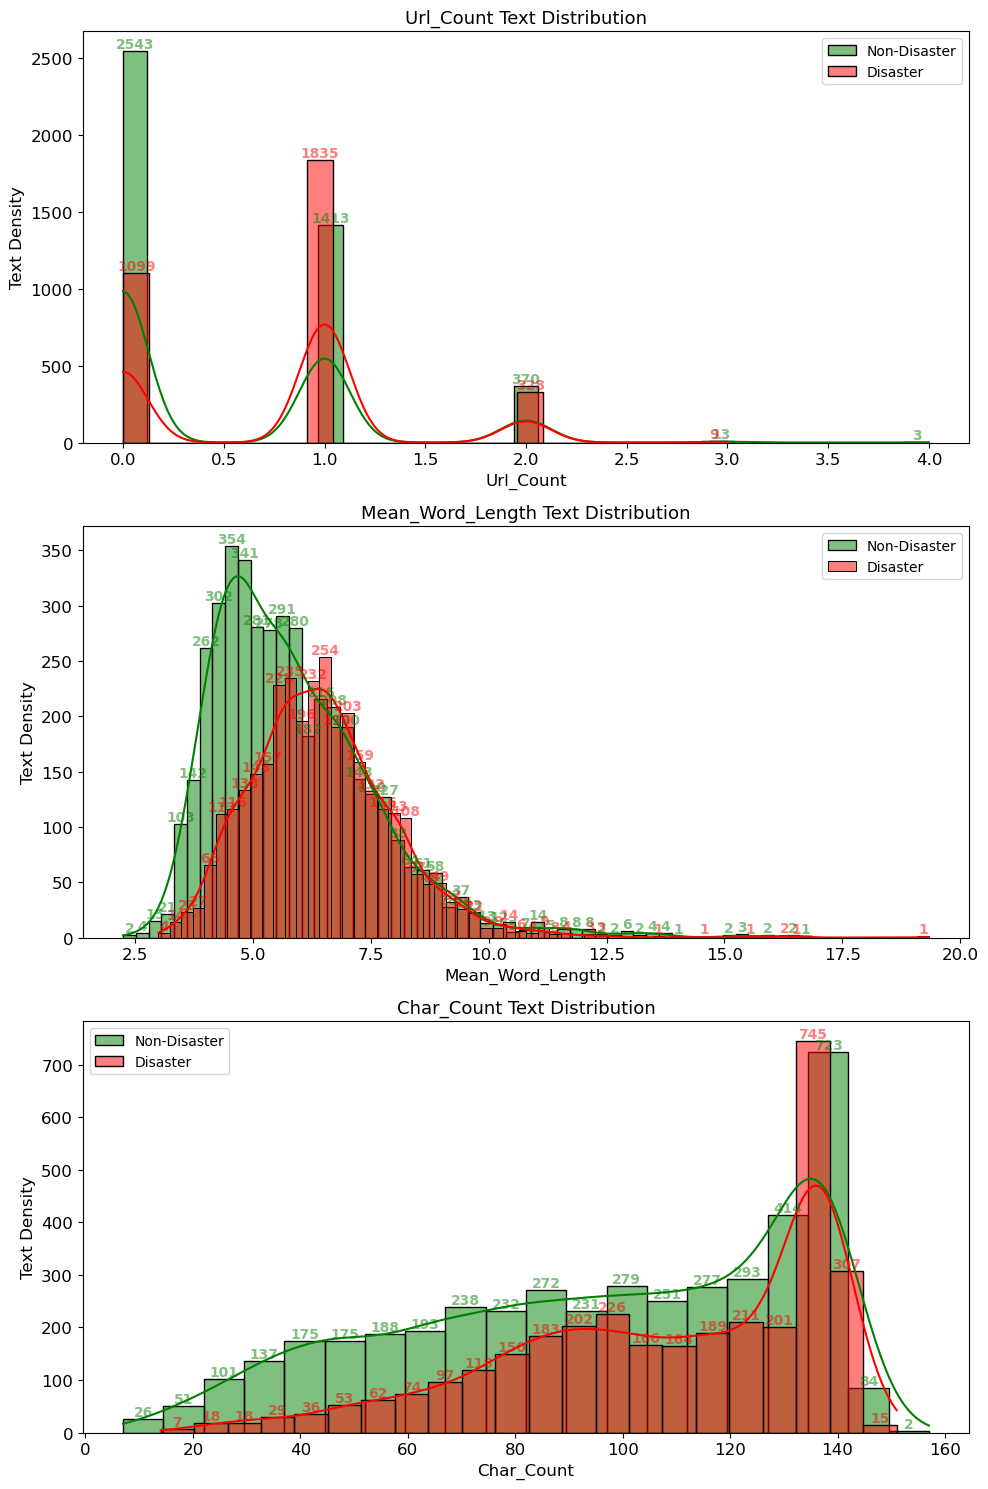

In [11]:
fig, axes = plt.subplots(nrows=3, figsize=(10, 15), dpi=100)

train['text'] = train['text'].apply(preprocess_text)
calculate_text_features(train)
features_to_plot = ['Url_Count', 'Mean_Word_Length', 'Char_Count']

for i, feature in enumerate(features_to_plot):
    plot_feature_distributions(train, feature, axes[i])

plt.tight_layout()
plt.show()


In examining the URL Text Distribution graph, distinct patterns emerge at various URL count intervals. Initially, at around 0.2 URL count, the text density for Disaster tweets is notably lower than that of Non-Disaster tweets, with 1099 and 2543 respectively. However, a shift occurs at the next data point of 1.0 URL count, where Disaster tweets surpass Non-Disaster tweets in text density, registering 1835 and 1413 respectively. The trend continues with a third data point at 2.0 URL count, where Non-Disaster tweets exhibit a higher text density than Disaster tweets, recording 370 and 328 respectively. Beyond this threshold, text density becomes sparser for both Disaster and Non-Disaster tweets.

Moving to the Mean Word Length text distribution graph, a notable contrast emerges in the pace at which Non-Disaster and Disaster tweets reach their peak text densities. Non-Disaster tweets accelerate swiftly to their apex, reaching 351 text density at a mean word length of 3.0, followed by a gradual decline. Conversely, Disaster tweets experience a more gradual ascent, culminating at approximately 254 text density around a mean word length of 6.0.

Examining the Char Count text distribution graph reveals a consistent trend of steady increase followed by a decline in text density for both Non-Disaster and Disaster tweets. Non-Disaster tweets peak at 723 text density and 140 character count, while Disaster tweets reach their zenith at 734 text density and 135 character count. Notably, there's a point of divergence where Disaster tweets surpass Non-Disaster tweets at 145 text character count, with 307 Disaster tweets compared to 84 Non-Disaster tweets.

Insights gleaned from all three graphs suggest nuanced differences in text characteristics between Disaster and Non-Disaster tweets. Despite some fluctuations, Disaster tweets tend to exhibit higher text density and longer mean word lengths compared to Non-Disaster tweets, particularly evident at specific thresholds such as URL count intervals and character counts. 

#### Punctuation, Hashtag, Mentions Text Distribution in Non-Disaster and Disaster Tweets

In [ ]:
fig, axes = plt.subplots(nrows=3, figsize=(10, 15), dpi=100)

train['text'] = train['text'].apply(preprocess_text)
calculate_text_features(train)
features_to_plot = ['Punctuation_Count', 'Hashtag_Count', 'Mention_Count']

for i, feature in enumerate(features_to_plot):
    plot_feature_distributions(train, feature, axes[i])

plt.tight_layout()
plt.show()


In the punctuation text distribution graph, both non-Disaster and Disaster tweets exhibit three distinct peaks. Non-Disaster tweets initially ascend steadily to the first peak at 400 text density and 2 punctuation count, then gradually decline to the second peak at 397 text density and 5 punctuation count, before tapering off to the third peak at 240 text density and 10 punctuation count. Conversely, Disaster tweets follow a different trajectory, ascending steadily to their first peak at 163 text density and 3 punctuation count, then sharply escalating to the second peak at 379 text density and 6 punctuation count, before slowly declining to their third peak at 200 text density and 11 punctuation count.

In the Hashtag count distribution graph, non-Disaster tweets initially dominate, with a text density of 3456 compared to 2396 for Disaster tweets, at 0 to 1 hashtag count. However, both lines quickly level off, showing similar text density of around 482 as the hashtag count increases. This trend continues as the hashtag count rises.

For the mention count distribution graph, non-Disaster tweets start with a higher text density (2979) compared to Disaster tweets (2595) at 0 to 0.5 mention count. The density then decreases steadily. Interestingly, at 3 mention count, both Disaster and non-Disaster tweets converge to similar text density, around 416, as the mention count decreases towards 0.

These distributions reveal nuanced patterns in tweet characteristics. The punctuation graph suggests that Disaster tweets tend to have more intense bursts of punctuation compared to non-Disaster tweets. Additionally, the Hashtag count graph illustrates a convergence of text density as hashtag count increases, indicating a similar engagement with hashtags across both tweet types. Lastly, the mention count graph showcases a shift from initially higher text density in non-Disaster tweets to eventual parity with Disaster tweets as mention count rises, hinting at a convergence in communication style as mention count increases.

In [ ]:
STOPWORDS = set(stopwords.words('english'))

def preprocess_text(text):
    text = re.sub(r'[^\w\s]', '', text.lower())
    return text

def generate_ngrams(text, n=1):
    tokens = text.split()
    ngrams = zip(*[tokens[i:] for i in range(n)])
    return [' '.join(ngram) for ngram in ngrams]

def count_ngrams(texts, n):
    ngram_counts = defaultdict(int)
    for text in texts:
        text = preprocess_text(text)
        for ngram in generate_ngrams(text, n):
            ngram_counts[ngram] += 1
    return ngram_counts

def plot_top_ngrams(ngram_counts, title, color, N, ax=None):
    counter = Counter(ngram_counts)
    df_ngrams = pd.DataFrame(counter.most_common(N), columns=['Ngram', 'Frequency'])
    if ax is None:
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Frequency', y='Ngram', data=df_ngrams, palette=color)
        plt.title(title)
        plt.xlabel('Frequency')
        plt.ylabel('Ngram')
    else:
        sns.barplot(x='Frequency', y='Ngram', data=df_ngrams, palette=color, ax=ax)
        ax.set_title(title)
        ax.set_xlabel('Frequency')
        ax.set_ylabel('Ngram')

    for i, (_, freq) in enumerate(df_ngrams.iterrows()):
        ax.text(freq['Frequency'], i, freq['Frequency'], color='black', ha="left", va="center")


N = 20  
disaster_texts = train[train['target']==1]['text']
non_disaster_texts = train[train['target']==0]['text']

fig, axs = plt.subplots(3, 2, figsize=(20, 25))

disaster_unigrams = count_ngrams(disaster_texts, 1)
non_disaster_unigrams = count_ngrams(non_disaster_texts, 1)
plot_top_ngrams(disaster_unigrams, f'Top {N} most common unigrams for Disaster Tweets', 'pastel', N, ax=axs[0, 0])
plot_top_ngrams(non_disaster_unigrams, f'Top {N} most common unigrams for Non-Disaster Tweets', 'muted', N, ax=axs[0, 1])

disaster_bigrams = count_ngrams(disaster_texts, 2)
non_disaster_bigrams = count_ngrams(non_disaster_texts, 2)
plot_top_ngrams(disaster_bigrams, f'Top {N} most common bigrams for Disaster Tweets', 'pastel', N, ax=axs[1, 0])
plot_top_ngrams(non_disaster_bigrams, f'Top {N} most common bigrams for Non-Disaster Tweets', 'muted', N, ax=axs[1, 1])

disaster_trigrams = count_ngrams(disaster_texts, 3)
non_disaster_trigrams = count_ngrams(non_disaster_texts, 3)
plot_top_ngrams(disaster_trigrams, f'Top {N} most common trigrams for Disaster Tweets', 'pastel', N, ax=axs[2, 0])
plot_top_ngrams(non_disaster_trigrams, f'Top {N} most common trigrams for Non-Disaster Tweets', 'muted', N, ax=axs[2, 1])

plt.tight_layout()
plt.show()

In the unigram graphs, the word 'the' reigns supreme, boasting the highest frequency in both Disaster and Non-Disaster Tweets, with 1357 and 1905 occurrences, respectively. Following closely behind, 'in' secures the second spot in Disaster Tweets with 1159 occurrences, while 'a' takes the runner-up position in Non-Disaster Tweets with 1252 occurrences. 'A' maintains its significance as the third most common word in Disaster Tweets, appearing 924 times, whereas 'to' claims this spot in Non-Disaster Tweets with 1188 occurrences. 'Of' clinches the fourth position in Disaster Tweets with 922 appearances, while 'i' takes its place in Non-Disaster Tweets with 1076 occurrences. Finally, 'to' emerges as the fifth most frequent word in Disaster Tweets (757 occurrences), while 'and' secures this rank in Non-Disaster Tweets (917 occurrences).

In the bigram graphs, 'in the' emerges as the dominant pair, boasting the highest frequency in both Disaster and Non-Disaster Tweets, with 144 and 163 occurrences, respectively. Following closely behind, 'of the' secures the second position in both Disaster and Non-Disaster Tweets, with 118 and 137 occurrences, respectively. In Disaster Tweets, 'suicide bomber' claims the third spot with 59 occurrences, whereas 'to the' takes this place in Non-Disaster Tweets with 89 occurrences. 'On the' follows suit as the fourth most common bigram in both Disaster and Non-Disaster Tweets, with 51 and 78 occurrences, respectively. Lastly, in Disaster Tweets, 'in a' emerges as the fifth most frequent bigram, appearing 50 times, while 'to be' secures this position in Non-Disaster Tweets with 73 occurrences.

Moving onto trigram graphs, phrases like 'northern california wildfire,' 'more homes razed,' and 'homes razed by' dominate the Disaster Tweets with the highest word frequency of 29. Conversely, in Non-Disaster Tweets, phrases like 'i liked a,' 'liked a youtube,' and 'a youtube video' claim the top spot with a frequency of 35. Additionally, phrases such as 'the latest more,' 'latest more homes,' 'razed by northern,' 'pkk suicide bomber,' 'suicide bomber who,' 'bomber who detonated,' and 'detonated bomb in' emerge as the second highest in Disaster Tweets with a frequency of 28. Meanwhile, 'reddit will now' and 'will now quarantine' hold this position in Non-Disaster Tweets with a frequency of 21.

These graphs showcase the nuanced differences in language usage between Disaster and Non-Disaster contexts. Disaster-related content tends to feature terms like 'wildfire,' 'homes razed,' and 'suicide bomber,' reflecting the urgency and gravity of such situations. Conversely, Non-Disaster Tweets are marked by more commonplace language, with phrases like 'liked a youtube video' and 'reddit will now quarantine' dominating the discourse. 

#### Data Cleaning and Standardized Text

In [ ]:
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map 
                           u"\U0001F1E0-\U0001F1FF"  # flags
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)

def cleaned_text(text):
    text = text.lower()
    table = str.maketrans('', '', string.punctuation)
    text = text.translate(table)
    text = re.sub(r'https?://\S+|www\.\S+', '', text) 
    text = re.sub(r'<.*?>', '', text) 
    text = emoji_pattern.sub(r'', text)
    return " ".join(text)

# Sample usage:
df = pd.concat([train_copy, test_copy])
df['text'] = df['text'].apply(cleaned_text)

In [ ]:
from spellchecker import SpellChecker

spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)
df['text']=df['text'].apply(lambda x : correct_spellings(x))

- Lowercasing: text = text.lower() converts all characters in the text to lowercase.
- Removing Punctuation: re.sub(r'[^\w\s]', '', text) removes any characters that are not alphanumeric or whitespace, including punctuation marks like periods, commas, and exclamation marks.
- Removing URLs: re.sub(r'https?://\S+|www\.\S+', '', text) removes URLs, matching both HTTP and HTTPS URLs as well as URLs without a protocol.
- Removing HTML tags: re.sub(r'<.*?>', '', text) removes HTML tags.
- Removing Emojis: emoji_pattern.sub(r'', text) removes emojis based on their Unicode code points.
- Tokenization: word_tokenize(text) tokenizes the text into individual words, spliting the text into words based on whitespace and punctuation.
- Removing Stopwords: [token for token in tokens if token not in stop_words] removes stopwords from the tokens, like "the", "is", "and", etc., that often don't carry much meaning.
- Stemming: [stemmer.stem(token) for token in tokens] stems each token using a stemming algorithm, reduces words to their root or base form, which helps in reducing the vocabulary size and capturing the essence of words. 

### Model Architecture

Describe your model architecture and reasoning for why you believe that specific architecture would be suitable for this problem. 

Since we did not learn NLP-specific techniques such as word embeddings in the lectures, we recommend looking at Kaggle tutorials, discussion boards, and code examples posted for this challenge.  You can use any resources needed, but make sure you “demonstrate” you understood by including explanations in your own words. Also importantly, please have a reference list at the end of the report.  

There are many methods to process texts to matrix form (word embedding), including TF-IDF, GloVe, Word2Vec, etc. Pick a strategy and process the raw texts to word embedding. Briefly explain the method(s) and how they work in your own words.

Build and train your sequential neural network model (You may use any RNN family neural network, including advanced architectures LSTM, GRU, bidirectional RNN, etc.). 

In [ ]:
import gensim.downloader as api
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, SpatialDropout1D, LSTM, Dense
from tensorflow.keras.initializers import Constant
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm

stop = set(stopwords.words('english'))
# Load GloVe embeddings
word_vectors = api.load("glove-wiki-gigaword-100")

def create_corpus(df):
    corpus=[]
    for tweet in tqdm(df['text']):
        words=[word.lower() for word in word_tokenize(tweet) if((word.isalpha()==1) & (word not in stop))]
        corpus.append(words)
    return corpus
    
corpus=create_corpus(df)
embedding_dict = {word: word_vectors[word] for word in word_vectors.key_to_index if word in corpus}

MAX_LEN=50
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)

tweet_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')
word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))

for word, i in tqdm(word_index.items()):
    if i > num_words:
        continue
    emb_vec = embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i] = emb_vec


model=Sequential()

embedding=Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))


optimzer=Adam(learning_rate=1e-5)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])
model.summary()

X_train, X_test, y_train, y_test = train_test_split(df['text'], df['target'], test_size=0.2, random_state=42)
print('Shape of train', X_train.shape)
print("Shape of Validation ", X_test.shape)
history = model.fit(X_train, y_train, batch_size=4, epochs=15, validation_data=(X_test, y_test), verbose=2)


### Results and Analysis

Run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance, and discuss what helped.

Includes results with tables and figures. There is an analysis of why or why not something worked well, troubleshooting, and a hyperparameter optimization procedure summary.

### Conclusion

Discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of your models? What improvements could you try in the future?